In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
import torch
import pickle
import random
import numpy as np
import scanpy as sc

import NEXUS 
from NEXUS.sample_emb.Graph_model import GraphVAE
from NEXUS.model_int.GNNExplainer_GNN.GNN_explainer import GraphEncoderWrapper, GNNexplainer_nexus, aggregate_graph_importance, extract_feature_importance, GNNexplainer_hotplot

In [3]:
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

In [4]:
input_path = "./../test_data/2_graph_emb_output/"
input_adata_path = input_path+'graph_embedded_adata.h5ad'
input_graph_dataset_path = input_path+"Graph_embedded.pickle"
input_model_param_path = input_path+"Graph_VAE_model.pt"
output_path = "./../test_data/4_GNNExplainer_output/"
label = "sample_cluster"

In [5]:
adata = sc.read_h5ad(input_adata_path)
with open(input_graph_dataset_path, 'rb') as file:
    graph_dataset = pickle.load(file)
graph_dataset = sorted(graph_dataset, key=lambda data: data.sample)

In [6]:
pooling_type = 'mean'
input_dim = 64
hidden_dim = 64
latent_dim = 32
heads = 4
edge_dims = 1

sample_id = 'sample_ID'
adata.obs['cluster'] = adata.obs[sample_id]
class_num = len(np.unique(adata.obs['cluster']))

In [7]:
model = GraphVAE(input_dim, hidden_dim, latent_dim, class_num, pooling_type = pooling_type, heads = heads, edge_dims = edge_dims)
checkpoint = torch.load(input_model_param_path, map_location=torch.device('cpu'), weights_only=False)
model.load_state_dict(checkpoint.state_dict())
Graph_encoder = model.encoder

In [8]:
GNNexplainer_nexus(adata, Graph_encoder, graph_dataset, epochs=100, save_path = output_path+"node_masks.pkl")

All node_mask have been saved to : ./../test_data/4_GNNExplainer_output/node_masks.pkl


{'0': array([[0.248223  , 0.2555094 , 0.26520208, ..., 0.3009507 , 0.25534105,
         0.27433607],
        [0.24981521, 0.30048892, 0.28057715, ..., 0.27402493, 0.27765656,
         0.28816238],
        [0.2855105 , 0.29679528, 0.23950416, ..., 0.28722638, 0.29135117,
         0.26425785],
        ...,
        [0.27456525, 0.26918092, 0.278156  , ..., 0.26689857, 0.26912573,
         0.51361066],
        [0.3008636 , 0.2902979 , 0.34555617, ..., 0.28106904, 0.29707533,
         0.7469663 ],
        [0.2892112 , 0.3068006 , 0.33072582, ..., 0.2686773 , 0.25466368,
         0.26777226]], dtype=float32),
 '1': array([[0.25373906, 0.2547745 , 0.30929935, ..., 0.23951928, 0.2811953 ,
         0.27063096],
        [0.26538712, 0.25171998, 0.28600228, ..., 0.30668274, 0.29672635,
         0.2403643 ],
        [0.2454651 , 0.34416926, 0.2911504 , ..., 0.27704096, 0.29658237,
         0.26154926],
        ...,
        [0.2548124 , 0.25446367, 0.25267413, ..., 0.25874823, 0.31250983,
         

In [9]:
input_path = "./../test_data/2_graph_emb_output/"

In [10]:
with open(input_path+"Graph_embedded.pickle", 'rb') as f:
    graph_dataset = pickle.load(f)
graph_dataset = sorted(graph_dataset, key=lambda data: data.sample)
adata_cell = sc.read_h5ad(input_path+"cell_embedded_adata.h5ad")
adata = sc.read_h5ad(input_path+'graph_embedded_adata.h5ad')
with open("./../test_data/4_GNNExplainer_output/node_masks.pkl", 'rb') as f:
    node_masks = pickle.load(f)

F:\Anaconda\envs\NEXUS\lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [11]:
importance_dict = aggregate_graph_importance(node_masks, aggregation='sum')
feature_importance = extract_feature_importance(importance_dict)

In [12]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# transpose -> scale rows -> transpose back
feature_importance_scaled = pd.DataFrame(
    scaler.fit_transform(feature_importance.T).T,
    index=feature_importance.index,
    columns=feature_importance.columns
)

In [13]:
sc.tl.rank_genes_groups(
    adata, 
    groupby='sample_cluster',  # 用于分组的obs列（如聚类结果、细胞类型）
    method='wilcoxon',  # 推荐用于单细胞数据的非参数检验
    n_genes=200,  # 每个组返回的差异基因数量
    key_added='rank_genes'  # 结果存储的键名（可选，默认是'rank_genes_groups'）
)

F:\Anaconda\envs\NEXUS\lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
F:\Anaconda\envs\NEXUS\lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
F:\Anaconda\envs\NEXUS\lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


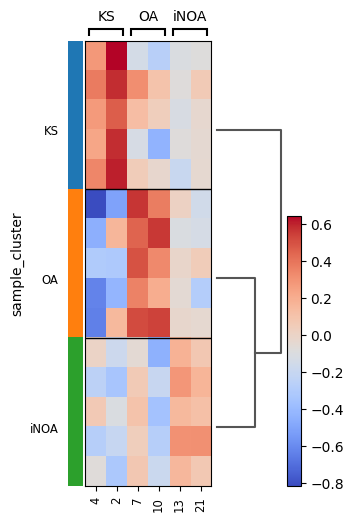

In [14]:
sc.pl.rank_genes_groups_heatmap(
    adata,
    key="rank_genes",
    n_genes=2,
    groupby="sample_cluster",
    show_gene_labels=True,
    cmap="coolwarm",  # 颜色映射（可选"coolwarm"）
    save="feature_importance.pdf"  # 按需保存
)